In [130]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pathlib
import pickle
import os
current_path = os.getcwd()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime, timedelta
import statistics
import time

import re

import pymysql  
from haversine import haversine

from geoband.API import *
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster
import geoplot as gplt
import geoplot.crs as gcrs
import imageio
import mapclassify as mc

import random
from functools import reduce
from collections import defaultdict

from IPython.display import display
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

import sklearn.cluster
import tensorflow as tf
import pydeck as pdk
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

import shapely
from shapely import wkt
from shapely.geometry import Polygon, Point, shape

# 최적화 solver
from mip import Model, xsum, maximize, BINARY  

# font 
import matplotlib.font_manager as font_manager
path = current_path+'/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path)

font_dirs = [current_path, ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['font.family'] = 'NanumBarunGothic'

In [2]:
# Data Load 
df_01 = pd.read_csv(current_path+'/input/1.수원시_버스정류장.csv')
df_02 = pd.read_csv(current_path+'/input/2.수원시_버스정류장별_승하차이력(1).csv')
df_03 = pd.read_csv(current_path+'/input/3.수원시_버스정류장별_승하차이력(2).csv')
df_04 = pd.read_csv(current_path+'/input/4.수원시_버스정류장별_승하차이력(3).csv')
df_05 = pd.read_csv(current_path+'/input/5.수원시_버스정류장별_승하차이력(4).csv')
df_06 = pd.read_csv(current_path+'/input/6.수원시_버스정류장별_승하차이력(5).csv')
df_07 = pd.read_csv(current_path+'/input/7.수원시_버스정류장별_노선현황.csv')
df_08 = pd.read_csv(current_path+'/input/8.수원시_지하철역_위치정보.csv')
df_09 = pd.read_csv(current_path+'/input/9.수원시_지하철역별_이용현황(2017~2019).csv')
df_10 = pd.read_csv(current_path+'/input/10.수원시_옥외광고물현황.csv')
df_11 = pd.read_csv(current_path+'/input/11.수원시_대기오염도_측정현황.csv')
df_12 = pd.read_csv(current_path+'/input/12.수원시_주차장현황.csv')
df_13 = pd.read_csv(current_path+'/input/13.수원시_기상데이터(2020).csv')
df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')
df_17 = gpd.read_file(current_path+'/input/17.수원시_인구정보(고령)_격자.geojson')
df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson')
df_19 = gpd.read_file(current_path+'/input/19.수원시_인구정보(유소년)_격자.geojson')
df_20 = gpd.read_file(current_path+'/input/20.수원시_교통노드.geojson')
df_21 = gpd.read_file(current_path+'/input/21.수원시_교통링크.geojson')
df_22 = gpd.read_file(current_path+'/input/22.수원시_상세도로망_LV6.geojson')
df_23 = pd.read_csv(current_path+'/input/23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
df_24 = pd.read_csv(current_path+'/input/24.수원시_평일_일별_혼잡빈도강도_LV6.csv')
df_25 = pd.read_csv(current_path+'/input/25.수원시_평일_일별_혼잡시간강도_LV6.csv')
df_26 = gpd.read_file(current_path+'/input/26.수원시_인도(2017).geojson')
df_27 = gpd.read_file(current_path+'/input/27.수원시_도로명주소(건물).geojson')
df_28 = gpd.read_file(current_path+'/input/28.수원시_건물연면적_격자.geojson')
df_29 = gpd.read_file(current_path+'/input/29.수원시_법정경계(시군구).geojson')
df_30 = gpd.read_file(current_path+'/input/30.수원시_법정경계(읍면동).geojson')
df_31 = gpd.read_file(current_path+'/input/31.수원시_행정경계(읍면동).geojson')
df_32 = gpd.read_file(current_path+'/input/32.수원시_지적도.geojson')

In [3]:
# pydeck function 
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 
 
def multipolygon_to_center_coordinates(x): 
    lon, lat = x[0].centroid.xy 
    return [[x, y] for x, y in zip(lon, lat)]

def polygon_to_center_coordinates(x): 
    lon, lat = x.centroid.xy
    return [[x, y] for x, y in zip(lon, lat)] 

In [4]:
token = "pk.eyJ1IjoiZGx3b3FsczQzMjMiLCJhIjoiY2tscnR3bG95MDJwaDJ2bjUzcTBrc3h4cyJ9.WigDFX0Gm612haaz4zQ2hg"

# 1. Bus Data  
* df_01 + df_07 
* df_02 ~ df_06 
---
* **경기 버스 정보** : http://www.gbis.go.kr/
* GGD_RouteInfo_M.xls : 버스 노선 정보 (기점, 종점 / 주중배차간격, 주말배차간격 / 첫차, 막차 시간) 
* GGD_RouteStationInfo_M.xls : 노선 경유 정보 (버스 노선 순서) 

## 1-1. tmp : df_01 + df_07 
* 버스 정보 합치기 
* 전처리 

In [5]:
# BIS = 1 & 인도 폭 0 or 4 이상인 정류장만 분석에 이용 
sidewalk = gpd.read_file(current_path+'/data/bus_filter_final.geojson')
sidewalk = sidewalk.drop(["layer", "path", "geometry"], axis=1)
sidewalk = sidewalk.drop_duplicates(["정류장ID"])

print(sidewalk.shape)
sidewalk.head()

(519, 14)


,정류장ID,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat
0,201000345,남수원초등학교,시내,일반,경기도 수원시 세류2동,nan,1,nan,nan,nan,1.000000,None,127.016000,37.251091
1,201000268,곡반중학교,시내,일반,경기도 수원시 곡선동,1.000000,1,1.000000,nan,nan,nan,None,127.034254,37.246081
2,201000357,수원은혜교회.한양수자인파크원아파트,시내,일반,경기도 수원시 금곡동,1.000000,1,nan,1.000000,nan,nan,None,126.953978,37.266016
3,202000090,화서역,"시내,마을",일반,경기도 수원시 화서2동,1.000000,1,nan,nan,1.000000,nan,None,126.990107,37.283895
4,202000092,월드메르디앙,시내,일반,경기도 수원시 우만2동,nan,1,nan,nan,1.000000,nan,None,127.037045,37.280164


In [6]:
tmp = sidewalk.merge(df_07[['정류소ID', '운행노선', '중앙차로여부']], how = 'left', left_on = '정류장ID', right_on = '정류소ID', copy = False)
del tmp['정류소ID']

## 1-2. tmp data preprocessing 

In [7]:
tmp.환승역타입 = '일반'
tmp.쉘터 = tmp.쉘터.fillna(0)

# LED / LCD / LED+LCD 
tmp.LED = tmp.LED.fillna(0)
tmp.LCD = tmp.LCD.fillna(0)
tmp['LED+LCD복합형'] = tmp['LED+LCD복합형'].fillna(0)

# 알뜰형 / 임대형(음성) 
tmp.알뜰형 = tmp.알뜰형.fillna(0)
tmp['임대형(음성)'] = tmp['임대형(음성)'].fillna(0)

In [8]:
# 운행노선 & 중앙차로여부 없는 데이터 drop 
tmp = tmp.dropna(axis=0)

In [9]:
# 결측값 확인 
tmp.isnull().sum()

정류장ID         0
정류장명          0
정류장유형         0
환승역타입         0
위치(동)         0
쉘터            0
BIS설치여부       0
LED           0
LCD           0
LED+LCD복합형    0
알뜰형           0
임대형(음성)       0
lon           0
lat           0
운행노선          0
중앙차로여부        0
dtype: int64

## 1-3. df_02 ~ df_06 

In [10]:
df_02_06 = pd.concat([df_02, df_03, df_04, df_05, df_06], axis=0, ignore_index = True)
df_02_06.shape

(2508607, 12)

In [11]:
# 노선번호 object 형태로 맞춰주기 
tqdm.pandas()
df_02_06["노선번호"] = df_02_06["노선번호"].progress_apply(lambda x : str(x))

100%|██████████| 2508607/2508607 [00:03<00:00, 767826.10it/s]


In [12]:
# '92' 처럼 용남고속 & 수원여객 동시운행 버스 통합  
df_02_06 = df_02_06.groupby(by=['일자', '정류소ID', '노선번호', '노선유형']).sum([['전체승차건수','초승건수','환승건수','전체하차건수','하차건수','미태그건수']]).reset_index()

In [13]:
# 기존 버스 데이터에 합치기 
bus = df_02_06.merge(tmp, how='left', left_on = '정류소ID', right_on = '정류장ID', copy = True).drop(['정류장ID'], axis=1)

In [14]:
# BIS 미설치 정류장 & 인도 폭 기준 미달 정류장 제외 
bus = bus.dropna(axis=0)

In [15]:
print("df_01 unique 정류장 ID 개수 : ", df_01["정류장ID"].nunique())
print("df_02~06 unique 정류장 ID 개수 : ", df_02_06["정류소ID"].nunique())

print("=====" * 20)
print("합치기 전 unique 정류장 ID 개수 : ", tmp["정류장ID"].nunique())
print("합친 후의 unique 정류장 ID 개수 : ", bus["정류소ID"].nunique())

df_01 unique 정류장 ID 개수 :  1179
df_02~06 unique 정류장 ID 개수 :  1114
합치기 전 unique 정류장 ID 개수 :  518
합친 후의 unique 정류장 ID 개수 :  516


## 1-4. 외부데이터 

In [16]:
route = pd.read_excel(current_path+'/data/GGD_RouteInfo_M.xls')
trans = pd.read_excel(current_path+'/data/GGD_RouteStationInfo_M.xls', sheet_name=[0,1,2])

In [17]:
trans = pd.concat([trans[0], trans[1], trans[2]], axis=0, ignore_index = True)

### (1) 버스 노선 순서 데이터 

In [18]:
# 버스 노선 순서 데이터 
trans2 = trans.rename(columns = {"STATION_ID": "정류소ID", "ROUTE_ID": "노선ID", "ROUTE_NM": "노선번호", "STA_ORDER": "노선순서", "STATION_NM": "정류장명"})
trans2 = trans2.drop(["순번", "MOBILE_NO"], axis=1)

In [19]:
trans2["노선번호"] = trans2["노선번호"].progress_apply(lambda x : str(x))
trans2["노선번호"] = trans2["노선번호"].progress_apply(lambda x : x.replace("-", "_"))

100%|██████████| 192708/192708 [00:00<00:00, 647836.61it/s]


In [20]:
# Data Merge 
tmp2 = bus.merge(trans2.drop(["정류장명"], axis=1), how='left', on=['정류소ID', '노선번호'])
print("bus+trans shape : ", tmp2.shape , '\n') 
print("원래 데이터의 unique bus 개수 : ", bus.정류소ID.nunique())
print("합친 데이터의 unique bus 개수 : ", tmp2.정류소ID.nunique())
print("=====" * 20)
tmp2.head()

bus+trans shape :  (1364613, 27) 

원래 데이터의 unique bus 개수 :  516
합친 데이터의 unique bus 개수 :  516


,일자,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서
0,20200101,200000006,13,일반형시내버스,166,160,6,67,67,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000037.000000,13.000000
1,20200101,200000006,37,일반형시내버스,36,33,3,0,0,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000099.000000,1.000000
2,20200101,200000006,7_1,일반형시내버스,187,162,25,190,190,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000045.000000,55.000000
3,20200101,200000008,13,일반형시내버스,127,127,0,46,46,0,문암골,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.027700,37.308946,13(수원여객),노변정류장,200000037.000000,11.000000
4,20200101,200000036,112,일반형시내버스,36,34,2,76,76,0,풍림아파트입구,"시내,마을",일반,경기도 수원시 정자3동,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,126.995257,37.297929,112(수원여객),노변정류장,200000049.000000,29.000000


### (2) 버스 노선 정보 데이터 

In [21]:
route["노선번호"] = route["노선번호"].progress_apply(lambda x : str(x))
route["노선번호"] = route["노선번호"].progress_apply(lambda x : x.replace("-", "_"))

100%|██████████| 3480/3480 [00:00<00:00, 434642.90it/s]


In [22]:
route = route[route["하행첫차"] != '1899/1']
print(route.shape)

(3479, 15)


In [23]:
# 상행첫차, 상행막차, 하행첫차, 하행막차 type 바꿔주기 
route['상행첫차'] = route['상행첫차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M'))
route['상행막차'] = route['상행막차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M'))
route['하행첫차'] = route['하행첫차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M'))
route['하행막차'] = route['하행막차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M'))

100%|██████████| 3479/3479 [00:00<00:00, 5097.05it/s]


In [24]:
# 운행시간 구하기 
def operation_time(first, last) : 
    if last >= first  : 
        return last - first 
    else : 
        last += timedelta(days=1)
        return last - first 

In [25]:
route["상행운행시간"] = route.progress_apply(lambda x : operation_time(x["상행첫차"], x["상행막차"]), axis=1)
route["하행운행시간"] = route.progress_apply(lambda x : operation_time(x["하행첫차"], x["하행막차"]), axis=1)

100%|██████████| 3479/3479 [00:00<00:00, 12841.02it/s]


In [26]:
# Data Merge 
tmp3 = pd.merge(left=tmp2, right=route.drop(["순번"], axis=1).drop_duplicates('노선ID'), how='left', \
                on=['노선ID','노선번호'])

print("bus+trans+route shape : ", tmp3.shape , '\n') 
print("bus 데이터의 unique bus 개수 : ", bus.정류소ID.nunique())
print("tmp2 데이터의 unique bus 개수 : ", tmp2.정류소ID.nunique())
print("합친 데이터의 unique bus 개수 : ", tmp3.정류소ID.nunique())
print("=====" * 20)
tmp3.head()

bus+trans+route shape :  (1364613, 41) 

bus 데이터의 unique bus 개수 :  516
tmp2 데이터의 unique bus 개수 :  516
합친 데이터의 unique bus 개수 :  516


,일자,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간
0,20200101,200000006,13,일반형시내버스,166,160,6,67,67,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000037.000000,13.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00
1,20200101,200000006,37,일반형시내버스,36,33,3,0,0,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000099.000000,1.000000,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000006.000000,한국민속촌.보라해링턴,228001646.000000,10분~13분,15분~20분,1900-01-01 04:50:00,1900-01-01 21:40:00,1900-01-01 06:00:00,1900-01-01 23:10:00,0 days 16:50:00,0 days 17:10:00
2,20200101,200000006,7_1,일반형시내버스,187,162,25,190,190,0,광교공원.경기대수원캠퍼스입구.연무시장,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.029464,37.300014,"13(수원여객),16(수원여객),16-1(수원여객),16-2(수원여객),32-5(수...",노변정류장,200000045.000000,55.000000,수원시,수원여객,동탄차고지,233001222.000000,광교공원.경기대수원캠퍼스입구.연무시장,200000006.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:40:00,1900-01-01 06:00:00,1900-01-01 23:45:00,0 days 17:40:00,0 days 17:45:00
3,20200101,200000008,13,일반형시내버스,127,127,0,46,46,0,문암골,시내,일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.027700,37.308946,13(수원여객),노변정류장,200000037.000000,11.000000,수원시,수원여객,상광교동종점,200000275.000000,칠보고등학교.칠보중학교.극동스타클래스,201000099.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00
4,20200101,200000036,112,일반형시내버스,36,34,2,76,76,0,풍림아파트입구,"시내,마을",일반,경기도 수원시 정자3동,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,126.995257,37.297929,112(수원여객),노변정류장,200000049.000000,29.000000,수원시,수원여객,곡반정동차고지,201000143.000000,웅비아파트,201000330.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:50:00,1900-01-01 06:05:00,1900-01-01 23:55:00,0 days 17:50:00,0 days 17:50:00


## 1-5. Reduce Memory Usage 

In [27]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df                

In [28]:
tmp3 = reduce_mem_usage(tmp3)

Mem. usage decreased to 285.01 Mb (34.8% reduction)


In [29]:
tmp3.isnull().sum()

일자                   0
정류소ID                0
노선번호                 0
노선유형                 0
전체 승차 건수             0
초승 건수                0
환승 건수                0
전체 하차 건수             0
하차 건수                0
미태그 건수               0
정류장명                 0
정류장유형                0
환승역타입                0
위치(동)                0
쉘터                   0
BIS설치여부              0
LED                  0
LCD                  0
LED+LCD복합형           0
알뜰형                  0
임대형(음성)              0
lon                  0
lat                  0
운행노선                 0
중앙차로여부               0
노선ID             33900
노선순서             33900
관할관청             33900
운행업체             33900
기점               33900
기점_STATION_ID    33900
종점               33900
종점_STATION_ID    33900
주중배차간격           36524
주말배차간격           38510
상행첫차             33900
상행막차             33900
하행첫차             35748
하행막차             35748
상행운행시간           33900
하행운행시간           35748
dtype: int64

## 1-6. dataframe split 
* 결측값 문제를 해결하기 위해 일단 데이터 split 
* 노선 정보가 없는 데이터는 고려하지 않아도 괜찮을 것 같음 

In [30]:
# 결측값 없는 dataframe index 
idx = tmp3.dropna(axis=0).index

final = tmp3.loc[idx]
final_na = tmp3[~tmp3.index.isin(idx)]

# check 
print("* 결측값 제외한 dataframe shape : ", final.shape) 
print("* 결측값 제외한 dataframe unique 버스정류장 개수 :", final.정류소ID.nunique())
print("=====" * 20)
print("* 결측값 있는 dataframe shape : ", final_na.shape)  
print("* 결측값 있는 dataframe unique 버스정류장 개수 :", final_na.정류소ID.nunique())

tmp3.shape[0] == (final.shape[0] + final_na.shape[0])

* 결측값 제외한 dataframe shape :  (1326103, 41)
* 결측값 제외한 dataframe unique 버스정류장 개수 : 516
* 결측값 있는 dataframe shape :  (38510, 41)
* 결측값 있는 dataframe unique 버스정류장 개수 : 173


True

In [31]:
final.isnull().sum()

일자               0
정류소ID            0
노선번호             0
노선유형             0
전체 승차 건수         0
초승 건수            0
환승 건수            0
전체 하차 건수         0
하차 건수            0
미태그 건수           0
정류장명             0
정류장유형            0
환승역타입            0
위치(동)            0
쉘터               0
BIS설치여부          0
LED              0
LCD              0
LED+LCD복합형       0
알뜰형              0
임대형(음성)          0
lon              0
lat              0
운행노선             0
중앙차로여부           0
노선ID             0
노선순서             0
관할관청             0
운행업체             0
기점               0
기점_STATION_ID    0
종점               0
종점_STATION_ID    0
주중배차간격           0
주말배차간격           0
상행첫차             0
상행막차             0
하행첫차             0
하행막차             0
상행운행시간           0
하행운행시간           0
dtype: int64

## 1-6. 추가 전처리 

In [33]:
# 일자 data type 바꿔주기 (오래걸림)
final['일자'] = final['일자'].progress_apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

100%|██████████| 1326103/1326103 [04:36<00:00, 4794.95it/s]


In [34]:
# 중앙차로여부 
final["중앙차로여부"] = final["중앙차로여부"].progress_apply(lambda x : 1 if x == '중앙차로 정류장' else 0)

100%|██████████| 1326103/1326103 [00:01<00:00, 689905.28it/s]


In [35]:
# 운행노선 / 정류장유형 
final["운행노선"] = final["운행노선"].progress_apply(lambda x : x.split(','))
final["운행노선수"] = final["운행노선"].progress_apply(lambda x : len(x))

final["정류장유형"] = final["정류장유형"].progress_apply(lambda x : x.split(','))
final["정류장유형수"] = final["정류장유형"].progress_apply(lambda x : len(x))

100%|██████████| 1326103/1326103 [00:01<00:00, 674554.77it/s]


## 1-7. Data Save 
* final 데이터로 나중에 다시 저장하기! 

In [65]:
Q1 = (tmp3['일자'] >= '2020-01-01') & (tmp3['일자'] <= '2020-03-31')
Q2 = (tmp3['일자'] >= '2020-04-01') & (tmp3['일자'] <= '2020-06-30')
Q3 = (tmp3['일자'] >= '2020-07-01') & (tmp3['일자'] <= '2020-09-30')
Q4 = (tmp3['일자'] >= '2020-10-01') & (tmp3['일자'] <= '2020-12-31')

In [66]:
Q1_df, Q2_df, Q3_df, Q4_df = tmp3.loc[Q1], tmp3.loc[Q2], tmp3.loc[Q3], tmp3.loc[Q4]
Q1_df.shape, Q2_df.shape, Q3_df.shape, Q4_df.shape

((325434, 43), (340074, 43), (346872, 43), (351871, 43))

In [67]:
# check 
tmp3.shape[0] == (Q1_df.shape[0] + Q2_df.shape[0] + Q3_df.shape[0] + Q4_df.shape[0])

True

In [68]:
# 저장 
Q1_df.to_excel(current_path+'/busdata/bus_Q1.xlsx', index=False)
Q2_df.to_excel(current_path+'/busdata/bus_Q2.xlsx', index=False)
Q3_df.to_excel(current_path+'/busdata/bus_Q3.xlsx', index=False)
Q4_df.to_excel(current_path+'/busdata/bus_Q4.xlsx', index=False)

## 1-8. Bus Stop Data 
* **busstop** : tmp (버스 고유 정보) + route + trans 
* 일별 정보 없는 **버스 정류장** 데이터

In [36]:
busstop = final.drop(['일자', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수', '하차 건수', '미태그 건수'], axis=1)
busstop = busstop.drop_duplicates(["정류소ID", "노선번호", '노선유형'])

print(busstop.shape)
print("unique 버스 정류장 개수 : ", busstop.정류소ID.nunique())
print("unique 버스 노선 개수 : ", busstop.노선번호.nunique())
print("=====" * 20)
busstop.head()

(3926, 36)
unique 버스 정류장 개수 :  516
unique 버스 노선 개수 :  135


,정류소ID,노선번호,노선유형,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간,운행노선수,정류장유형수
0,200000006,13,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000032.000000,13.000000,수원시,수원여객,상광교동종점,200000272.000000,칠보고등학교.칠보중학교.극동스타클래스,201000096.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,9,1
1,200000006,37,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000096.000000,1.000000,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000000.000000,한국민속촌.보라해링턴,228001648.000000,10분~13분,15분~20분,1900-01-01 04:50:00,1900-01-01 21:40:00,1900-01-01 06:00:00,1900-01-01 23:10:00,0 days 16:50:00,0 days 17:10:00,9,1
2,200000006,7_1,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000048.000000,55.000000,수원시,수원여객,동탄차고지,233001216.000000,광교공원.경기대수원캠퍼스입구.연무시장,200000000.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:40:00,1900-01-01 06:00:00,1900-01-01 23:45:00,0 days 17:40:00,0 days 17:45:00,9,1
3,200000008,13,일반형시내버스,문암골,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,[13(수원여객)],0,200000032.000000,11.000000,수원시,수원여객,상광교동종점,200000272.000000,칠보고등학교.칠보중학교.극동스타클래스,201000096.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,1,1
4,200000036,112,일반형시내버스,풍림아파트입구,"[시내, 마을]",일반,경기도 수원시 정자3동,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,[112(수원여객)],0,200000048.000000,29.000000,수원시,수원여객,곡반정동차고지,201000144.000000,웅비아파트,201000336.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:50:00,1900-01-01 06:05:00,1900-01-01 23:55:00,0 days 17:50:00,0 days 17:50:00,1,2


In [37]:
# 해당 노선의 총 승차건수 데이터 
busstop_tmp = final.groupby(by=['정류소ID', '노선번호', '노선유형']).sum([['전체승차건수','초승건수','환승건수','전체하차건수','하차건수','미태그건수']]).reset_index()

In [38]:
# Data Merge 
busstop = pd.merge(left=busstop, right=busstop_tmp[['정류소ID', '노선번호', '노선유형', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수', '하차 건수', '미태그 건수']], 
                   how='left', on=['정류소ID', '노선번호', '노선유형'])

print("bus 노선 정보 dataframe shape : ", busstop.shape , '\n') 
print("합친 데이터의 unique bus 개수 : ", busstop.정류소ID.nunique())
print("=====" * 20)
busstop.head()

bus 노선 정보 dataframe shape :  (3926, 42) 

합친 데이터의 unique bus 개수 :  516


,정류소ID,노선번호,노선유형,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간,운행노선수,정류장유형수,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수
0,200000006,13,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000032.000000,13.000000,수원시,수원여객,상광교동종점,200000272.000000,칠보고등학교.칠보중학교.극동스타클래스,201000096.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,9,1,77601.000000,75292.000000,2309.000000,18709.000000,18709.000000,0
1,200000006,37,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000096.000000,1.000000,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000000.000000,한국민속촌.보라해링턴,228001648.000000,10분~13분,15분~20분,1900-01-01 04:50:00,1900-01-01 21:40:00,1900-01-01 06:00:00,1900-01-01 23:10:00,0 days 16:50:00,0 days 17:10:00,9,1,17785.000000,15898.000000,1887.000000,1757.000000,1757.000000,0
2,200000006,7_1,일반형시내버스,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000048.000000,55.000000,수원시,수원여객,동탄차고지,233001216.000000,광교공원.경기대수원캠퍼스입구.연무시장,200000000.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:40:00,1900-01-01 06:00:00,1900-01-01 23:45:00,0 days 17:40:00,0 days 17:45:00,9,1,86644.000000,77766.000000,8878.000000,76997.000000,76997.000000,0
3,200000008,13,일반형시내버스,문암골,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,[13(수원여객)],0,200000032.000000,11.000000,수원시,수원여객,상광교동종점,200000272.000000,칠보고등학교.칠보중학교.극동스타클래스,201000096.000000,5분~7분,5분~7분,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,1,1,28287.000000,28178.000000,109.000000,13357.000000,13357.000000,0
4,200000036,112,일반형시내버스,풍림아파트입구,"[시내, 마을]",일반,경기도 수원시 정자3동,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,[112(수원여객)],0,200000048.000000,29.000000,수원시,수원여객,곡반정동차고지,201000144.000000,웅비아파트,201000336.000000,7분~9분,9분~12분,1900-01-01 05:00:00,1900-01-01 22:50:00,1900-01-01 06:05:00,1900-01-01 23:55:00,0 days 17:50:00,0 days 17:50:00,1,2,26713.000000,24373.000000,2340.000000,36175.000000,36175.000000,0


In [39]:
busstop.isnull().sum()

정류소ID            0
노선번호             0
노선유형             0
정류장명             0
정류장유형            0
환승역타입            0
위치(동)            0
쉘터               0
BIS설치여부          0
LED              0
LCD              0
LED+LCD복합형       0
알뜰형              0
임대형(음성)          0
lon              0
lat              0
운행노선             0
중앙차로여부           0
노선ID             0
노선순서             0
관할관청             0
운행업체             0
기점               0
기점_STATION_ID    0
종점               0
종점_STATION_ID    0
주중배차간격           0
주말배차간격           0
상행첫차             0
상행막차             0
하행첫차             0
하행막차             0
상행운행시간           0
하행운행시간           0
운행노선수            0
정류장유형수           0
전체 승차 건수         0
초승 건수            0
환승 건수            0
전체 하차 건수         0
하차 건수            0
미태그 건수           0
dtype: int64

In [ ]:
# 저장 
busstop.to_excel(current_path+'/busdata/busstop_0316.xlsx', index=False)

# 2. Bus Data Feature Engineering 
1. **tmp** (518, 16) : 버스 정류장 고유 정보 데이터, df_01 + df_07 
2. **busstop** (3921, 36) : tmp (버스 고유 정보) + route + trans
3. **final** (1326103, 43) : 일별 노선 승하차 정보 포함 데이터 

* **tmp** 데이터에 맞춰서 (**버스 정류장ID** 기준으로), 데이터 만들기 
* 첫차시간: 가장 빠른 첫차시간 / 막차시간 : 가장 느린 막차시간 
---
* 주중 / 주말 운행 버스 개수 

In [ ]:
# Load final data & data merge 
Q1_df = pd.read_excel(current_path+'/busdata/bus_Q1.xlsx')
Q2_df = pd.read_excel(current_path+'/busdata/bus_Q2.xlsx')
Q3_df = pd.read_excel(current_path+'/busdata/bus_Q3.xlsx')
Q4_df = pd.read_excel(current_path+'/busdata/bus_Q4.xlsx')

total = pd.concat([Q1_df, Q2_df, Q3_df, Q4_df], axis=0)

# check 
total.shape[0] == (Q1_df.shape[0] + Q2_df.shape[0] + Q3_df.shape[0] + Q4_df.shape[0])

In [151]:
busstop = pd.read_excel(current_path+'/busdata/busstop_0316.xlsx')

In [153]:
# data reload 시 실행 ! 
busstop['상행첫차'] = busstop['상행첫차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M:%S'))
busstop['상행막차'] = busstop['상행막차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M:%S'))
busstop['하행첫차'] = busstop['하행첫차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M:%S'))
busstop['하행막차'] = busstop['하행막차'].progress_apply(lambda x: pd.to_datetime(str(x), format='%H:%M:%S'))

100%|██████████| 3926/3926 [00:00<00:00, 5457.68it/s]


In [155]:
# data reload 시 실행 ! 
busstop["상행운행시간"] = busstop.progress_apply(lambda x : operation_time(x["상행첫차"], x["상행막차"]), axis=1)
busstop["하행운행시간"] = busstop.progress_apply(lambda x : operation_time(x["하행첫차"], x["하행막차"]), axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 12822.87it/s]


## 2-1. busstop data Feature Engineering 
* 버스 노선 고유 정보 feature engineering 

### (1) 배차 간격 

In [40]:
# 간격은 다 '분' 으로 표현 
busstop[(busstop["주중배차간격"].str.contains("~")) & (busstop["주중배차간격"].str.contains("분") == False)].shape

(0, 42)

In [41]:
# 배차간격 
def interval(x) : 
    try : 
        itv = x.split("~")
        a, b = int(itv[0][:-1]), int(itv[1][:-1])
        return (a+b)/2
    except :
        return int(x[:-1])

In [42]:
# 분 단위 배차간격 
busstop["주중배차간격(분)"] = busstop["주중배차간격"].progress_apply(lambda x : interval(x))
busstop["주말배차간격(분)"] = busstop["주말배차간격"].progress_apply(lambda x : interval(x))

busstop = busstop.drop(["주중배차간격", "주말배차간격"], axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 346750.56it/s]


### (2) 배차 횟수

In [45]:
# 배차횟수 = 운행시간 / 배차간격 
def operation_num(duration, interval) : 
    duration2, interval2 = duration.total_seconds() , interval * 60
    return duration2 / interval2

In [46]:
busstop["주중상행배차횟수"] = busstop.progress_apply(lambda x : operation_num(x["상행운행시간"], x["주중배차간격(분)"]), axis=1)
busstop["주중하행배차횟수"] = busstop.progress_apply(lambda x : operation_num(x["하행운행시간"], x["주중배차간격(분)"]), axis=1)

busstop["주말상행배차횟수"] = busstop.progress_apply(lambda x : operation_num(x["상행운행시간"], x["주말배차간격(분)"]), axis=1)
busstop["주말하행배차횟수"] = busstop.progress_apply(lambda x : operation_num(x["하행운행시간"], x["주말배차간격(분)"]), axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 14514.95it/s]


### (3) 버스 유형 

In [47]:
busstop.노선유형.value_counts()

일반형시내버스          3225
직행좌석형시내버스         546
좌석형시내버스            77
광역급행형시내버스          46
맞춤형시내버스            21
경기순환버스(직행좌석형)      11
Name: 노선유형, dtype: int64

<AxesSubplot:xlabel='노선유형', ylabel='전체 승차 건수'>

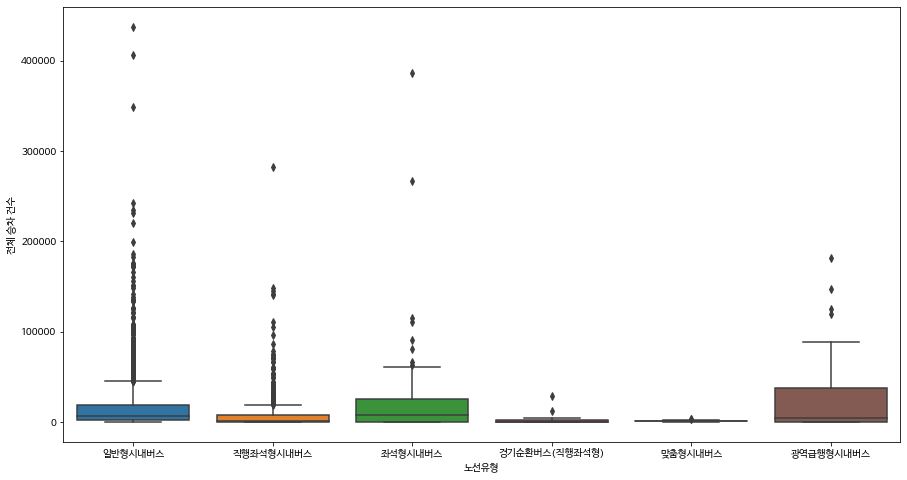

In [48]:
# 노선 유형 vs 전체 승차 건수 
plt.figure(figsize=(15, 8))
sns.boxplot(x='노선유형', y='전체 승차 건수', data=busstop)

<AxesSubplot:xlabel='노선유형', ylabel='전체 승차 건수'>

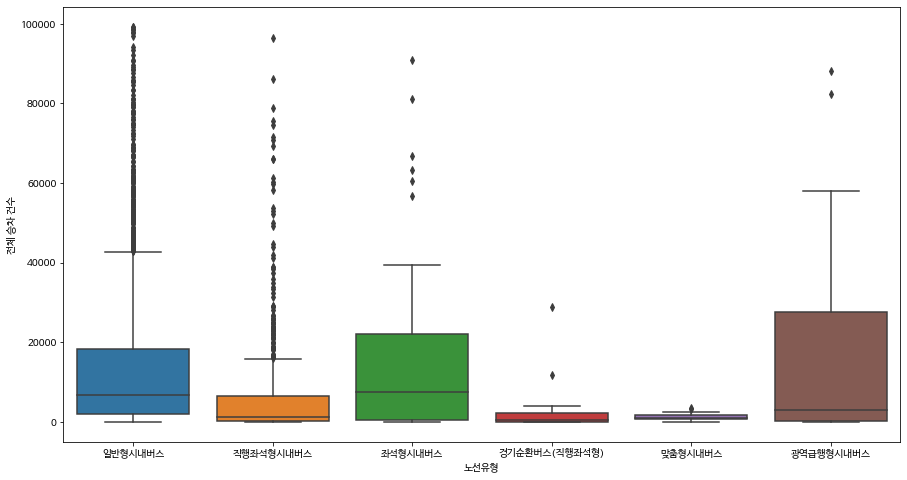

In [49]:
# 이상점 제외하고 본 버스 유형 당 승차 건수 
plt.figure(figsize=(15, 8))
sns.boxplot(x='노선유형', y='전체 승차 건수', data=busstop[busstop["전체 승차 건수"] <= 100000])

In [50]:
busstop = pd.get_dummies(busstop, columns=["노선유형"])
print(busstop.shape)
busstop.head()

(3926, 51)


,정류소ID,노선번호,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간,운행노선수,정류장유형수,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수,주중배차간격(분),주말배차간격(분),주중상행배차횟수,주중하행배차횟수,주말상행배차횟수,주말하행배차횟수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스
0,200000006,13,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000032.000000,13.000000,수원시,수원여객,상광교동종점,200000272.000000,칠보고등학교.칠보중학교.극동스타클래스,201000096.000000,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,9,1,77601.000000,75292.000000,2309.000000,18709.000000,18709.000000,0,6.000000,6.000000,160.000000,175.000000,160.000000,175.000000,0,0,0,1,0,0
1,200000006,37,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000096.000000,1.000000,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000000.000000,한국민속촌.보라해링턴,228001648.000000,1900-01-01 04:50:00,1900-01-01 21:40:00,1900-01-01 06:00:00,1900-01-01 23:10:00,0 days 16:50:00,0 days 17:10:00,9,1,17785.000000,15898.000000,1887.000000,1757.000000,1757.000000,0,11.500000,17.500000,87.826087,89.565217,57.714286,58.857143,0,0,0,1,0,0
2,200000006,7_1,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000048.000000,55.000000,수원시,수원여객,동탄차고지,233001216.000000,광교공원.경기대수원캠퍼스입구.연무시장,200000000.000000,1900-01-01 05:00:00,1900-01-01 22:40:00,1900-01-01 06:00:00,1900-01-01 23:45:00,0 days 17:40:00,0 days 17:45:00,9,1,86644.000000,77766.000000,8878.000000,76997.000000,76997.000000,0,8.000000,10.500000,132.500000,133.125000,100.952381,101.428571,0,0,0,1,0,0
3,200000008,13,문암골,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,[13(수원여객)],0,200000032.000000,11.000000,수원시,수원여객,상광교동종점,200000272.000000,칠보고등학교.칠보중학교.극동스타클래스,201000096.000000,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,1,1,28287.000000,28178.000000,109.000000,13357.000000,13357.000000,0,6.000000,6.000000,160.000000,175.000000,160.000000,175.000000,0,0,0,1,0,0
4,200000036,112,풍림아파트입구,"[시내, 마을]",일반,경기도 수원시 정자3동,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,[112(수원여객)],0,200000048.000000,29.000000,수원시,수원여객,곡반정동차고지,201000144.000000,웅비아파트,201000336.000000,1900-01-01 05:00:00,1900-01-01 22:50:00,1900-01-01 06:05:00,1900-01-01 23:55:00,0 days 17:50:00,0 days 17:50:00,1,2,26713.000000,24373.000000,2340.000000,36175.000000,36175.000000,0,8.000000,10.500000,133.750000,133.750000,101.904762,101.904762,0,0,0,1,0,0


### (4) 노선 별 승차 건수 비율 
* 향후 우리가 이용할 데이터의 y 는 **정류장** 에 대한 **전체 승차 건수** 
* 버스 **노선** 별로 통계량 구한 것은 괜찮지 않을까 .. 생각... 

In [51]:
print("1년 내내 승차한 버스 승객이 0 명인 버스 노선 : ", busstop[busstop["전체 승차 건수"] == 0].shape) 
print("1년 내내 하차한 버스 승객이 0 명인 버스 노선 : ", busstop[busstop["전체 하차 건수"] == 0].shape) 

1년 내내 승차한 버스 승객이 0 명인 버스 노선 :  (4, 51)
1년 내내 하차한 버스 승객이 0 명인 버스 노선 :  (3, 51)


In [52]:
def div(col1, col2) : 
    try : 
        return col1 / col2 
    except : 
        return 0 

In [53]:
# 초승 환승 전체승차 하차 
busstop["초승_환승비율"] = busstop.progress_apply(lambda x : div(x['초승 건수'], x['환승 건수']), axis=1)
busstop["초승_승차비율"] = busstop.progress_apply(lambda x : div(x['초승 건수'], x['전체 승차 건수']), axis=1)
busstop["초승_하차비율"] = busstop.progress_apply(lambda x : div(x['초승 건수'], x['전체 하차 건수']), axis=1)

busstop["환승_승차비율"] = busstop.progress_apply(lambda x : div(x['환승 건수'], x['전체 승차 건수']), axis=1)
busstop["환승_하차비율"] = busstop.progress_apply(lambda x : div(x['환승 건수'], x['전체 하차 건수']), axis=1)

busstop["승차_하차비율"] = busstop.progress_apply(lambda x : div(x['전체 승차 건수'], x['전체 하차 건수']), axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 15268.39it/s]


### (5) 승차 많은 / 환승 많은 / 하차 많은 버스 노선 
* 분모 : 전체 승차 건수 + 전체 하차 건수 
* 분자 : 승차 건수 / 환승 건수 / 하차 건수 

In [56]:
busstop["전체승하차건수"] = busstop.progress_apply(lambda x : x['전체 승차 건수'] + x['전체 하차 건수'], axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 15391.32it/s]


In [58]:
busstop["승차비율"] = busstop.progress_apply(lambda x : div(x['초승 건수'], x['전체승하차건수']), axis=1)
busstop["환승비율"] = busstop.progress_apply(lambda x : div(x['환승 건수'], x['전체승하차건수']), axis=1)
busstop["하차비율"] = busstop.progress_apply(lambda x : div(x['하차 건수'], x['전체승하차건수']), axis=1)

100%|██████████| 3926/3926 [00:00<00:00, 14691.45it/s]


In [61]:
print("승차 많은 버스 노선 개수 : ", busstop[busstop["승차비율"] > 0.5].shape[0])
print("환승 많은 버스 노선 개수 : ", busstop[busstop["환승비율"] > 0.5].shape[0])
print("하차 많은 버스 노선 개수 : ", busstop[busstop["하차비율"] > 0.5].shape[0])

승차 많은 버스 노선 개수 :  1311
환승 많은 버스 노선 개수 :  63
하차 많은 버스 노선 개수 :  1984


In [78]:
# 비율 체크 
def below_threshold(threshold, dataframe, ratiolist) : 
    cnt = 0 
    for ratio in dataframe[ratiolist] : 
        if ratio > threshold : 
            cnt += 1 
    print("{}이 {} 이상인 버스 노선 개수 : {} & 비율 : {:.4f}".format(ratiolist, threshold, cnt, (cnt / len(dataframe))))

In [79]:
below_threshold(0.7, busstop, "승차비율")
below_threshold(0.3, busstop, "환승비율")
below_threshold(0.8, busstop, "하차비율")

승차비율이 0.7 이상인 버스 노선 개수 : 555 & 비율 : 0.1414
환승비율이 0.3 이상인 버스 노선 개수 : 248 & 비율 : 0.0632
하차비율이 0.8 이상인 버스 노선 개수 : 700 & 비율 : 0.1783


In [81]:
busstop["승차많은버스"] = busstop["승차비율"].progress_apply(lambda x : 1 if x > 0.7 else 0)
busstop["환승많은버스"] = busstop["환승비율"].progress_apply(lambda x : 1 if x > 0.3 else 0)
busstop["하차많은버스"] = busstop["하차비율"].progress_apply(lambda x : 1 if x > 0.8 else 0)

100%|██████████| 3926/3926 [00:00<00:00, 634193.63it/s]


In [82]:
print(busstop.shape)
busstop.head(3)

(3926, 64)


,정류소ID,노선번호,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간,운행노선수,정류장유형수,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수,주중배차간격(분),주말배차간격(분),주중상행배차횟수,주중하행배차횟수,주말상행배차횟수,주말하행배차횟수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,전체승하차건수,승차비율,환승비율,하차비율,승차많은버스,환승많은버스,하차많은버스
0,200000006,13,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000032.000000,13.000000,수원시,수원여객,상광교동종점,200000272.000000,칠보고등학교.칠보중학교.극동스타클래스,201000096.000000,1900-01-01 06:00:00,1900-01-01 22:00:00,1900-01-01 05:40:00,1900-01-01 23:10:00,0 days 16:00:00,0 days 17:30:00,9,1,77601.000000,75292.000000,2309.000000,18709.000000,18709.000000,0,6.000000,6.000000,160.000000,175.000000,160.000000,175.000000,0,0,0,1,0,0,32.608055,0.970245,4.024373,0.029755,0.123417,4.147790,96310.000000,0.781767,0.023975,0.194258,1,0,0
1,200000006,37,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000096.000000,1.000000,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000000.000000,한국민속촌.보라해링턴,228001648.000000,1900-01-01 04:50:00,1900-01-01 21:40:00,1900-01-01 06:00:00,1900-01-01 23:10:00,0 days 16:50:00,0 days 17:10:00,9,1,17785.000000,15898.000000,1887.000000,1757.000000,1757.000000,0,11.500000,17.500000,87.826087,89.565217,57.714286,58.857143,0,0,0,1,0,0,8.425013,0.893899,9.048378,0.106101,1.073990,10.122368,19542.000000,0.813530,0.096561,0.089909,1,0,0
2,200000006,7_1,광교공원.경기대수원캠퍼스입구.연무시장,[시내],일반,경기도 수원시 연무동,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,127.000000,37.312500,"[13(수원여객), 16(수원여객), 16-1(수원여객), 16-2(수원여객), 3...",0,200000048.000000,55.000000,수원시,수원여객,동탄차고지,233001216.000000,광교공원.경기대수원캠퍼스입구.연무시장,200000000.000000,1900-01-01 05:00:00,1900-01-01 22:40:00,1900-01-01 06:00:00,1900-01-01 23:45:00,0 days 17:40:00,0 days 17:45:00,9,1,86644.000000,77766.000000,8878.000000,76997.000000,76997.000000,0,8.000000,10.500000,132.500000,133.125000,100.952381,101.428571,0,0,0,1,0,0,8.759405,0.897535,1.009987,0.102465,0.115303,1.125291,163641.000000,0.475223,0.054253,0.470524,0,0,0


### (6) 승하차 많은 정류장 
* 주요 버정 체크! 
* 토크나이징 해서 넣는게 나을 것 같기도 하구 .. 
* str.contains 로는 안 될 것 같고, Counter 이용해서 쓰기에는 토크나이징 한 후에 쓰는 것이 나을 것 같구 .. 

In [87]:
busstop[busstop["전체승하차건수"] > 100000].shape

(202, 64)

In [187]:
freq_bus = list(set(busstop.sort_values(["전체승하차건수"], ascending=False).head(202)["정류장명"]))
freq_bus = [re.sub(r'[@%\\*=()/~&\+á?\xc3\xa1\.\,\-\|\:\;\!\-\,\_\~\$\'\"\“]', '  ', x).split(' ') for x in freq_bus]
freq_bus = list(set([y for x in freq_bus for y in x]))
freq_bus.remove('')

In [188]:
print("승하차 많은 정류장 단어 개수 : ", len(freq_bus))

승하차 많은 정류장 단어 개수 :  100


In [189]:
freq_bus[:10]

['수원버스터미널',
 '롯데아울렛',
 '국민연금공단',
 '8승강장',
 '광교중앙역',
 '동수원우체국',
 '수원백병원',
 '광교중앙',
 '아주대',
 '수원시청역3번출구']

In [ ]:
# 이것도 하고 싶음 ..
busstop[busstop["종점"].str.contains("사당")]

### (7) 버스 정류장 사이의 거리 

In [205]:
dist = df_02_06.drop_duplicates(["정류소ID", "노선번호", "노선유형"])
print(dist.shape)

(7666, 10)


In [206]:
dist.head()

,일자,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,하차 건수,미태그 건수
0,20200101,200000001,13,일반형시내버스,1,1,0,5,5,0
1,20200101,200000002,13,일반형시내버스,0,0,0,31,31,0
2,20200101,200000004,13,일반형시내버스,4,4,0,39,39,0
3,20200101,200000005,13,일반형시내버스,46,37,9,261,261,0
4,20200101,200000006,13,일반형시내버스,166,160,6,67,67,0


In [207]:
tmp_bus = df_01.merge(df_07[['정류소ID','운행노선','중앙차로여부']], how = 'outer',left_on = '정류장ID',right_on = '정류소ID', copy = False)
del tmp_bus['정류소ID']

In [225]:
tmp_bus = tmp_bus[["정류장ID", "정류장명", "위치(동)", 'lon', 'lat']].rename(columns = {"정류장ID" : "정류소ID"})
dist = dist[["정류소ID", "노선번호"]]

tmp_route = route[["노선번호", "노선ID"]]
tmp_trans = trans2[["정류소ID", "정류장명", "노선ID", "노선번호", "노선순서"]]

tmp_bus.shape, dist.shape, tmp_route.shape, tmp_trans.shape

((1179, 5), (7666, 2), (3479, 2), (192708, 5))

In [231]:
route.head()

,순번,관할관청,운행업체,노선번호,노선ID,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간
0,1,가평군,가평교통,50_5,239000002,목동터미널,239000272,용수동종점,239000052,370분,370분,1900-01-01 09:20:00,1900-01-01 19:00:00,1900-01-01 10:10:00,1900-01-01 19:50:00,0 days 09:40:00,0 days 09:40:00
1,2,가평군,가평교통,40_5,239000005,현리터미널,239000687,귀목종점,239000123,270분,270분,1900-01-01 06:40:00,1900-01-01 17:00:00,1900-01-01 07:10:00,1900-01-01 17:30:00,0 days 10:20:00,0 days 10:20:00
2,3,가평군,가평교통,43,239000006,현리터미널,239000687,청평터미널,239000738,120분,120분,1900-01-01 06:00:00,1900-01-01 19:00:00,1900-01-01 06:20:00,1900-01-01 19:30:00,0 days 13:00:00,0 days 13:10:00
3,4,가평군,가평교통,40_6,239000007,현리터미널,239000687,독박골,239000939,310분,310분,1900-01-01 07:20:00,1900-01-01 16:40:00,1900-01-01 07:40:00,1900-01-01 17:00:00,0 days 09:20:00,0 days 09:20:00
4,5,가평군,가평교통,30_5,239000010,청평터미널,239000738,고재,239000496,130분,130분,1900-01-01 06:20:00,1900-01-01 20:00:00,1900-01-01 06:50:00,1900-01-01 20:30:00,0 days 13:40:00,0 days 13:40:00


In [232]:
tmp_bus.head()

,정류소ID,정류장명,위치(동),lon,lat
0,201000313,권선구청,경기도 수원시 서둔동,126.970983,37.256983
1,201000344,중보들공원,경기도 수원시 평동,126.991029,37.244605
2,201000345,남수원초등학교,경기도 수원시 세류2동,127.016000,37.251091
3,201000379,신미주아파트,경기도 수원시 금곡동,126.953845,37.268806
4,201000055,농수산물시장,경기도 수원시 권선1동,127.029815,37.256755


In [230]:
# Data Merge 
tmp_bus2 = tmp_bus.merge(tmp_trans.drop(["정류장명"], axis=1), how='left', on=['정류소ID'])
print("bus+trans shape : ", tmp_bus2.shape , '\n') 
print("원래 데이터의 unique bus 개수 : ", tmp_bus.정류소ID.nunique())
print("합친 데이터의 unique bus 개수 : ", tmp_bus2.정류소ID.nunique())
print("=====" * 20)
tmp_bus2.head()

bus+trans shape :  (8620, 8) 

원래 데이터의 unique bus 개수 :  1179
합친 데이터의 unique bus 개수 :  1179


,정류소ID,정류장명,위치(동),lon,lat,노선ID,노선번호,노선순서
0,201000313,권선구청,경기도 수원시 서둔동,126.970983,37.256983,200000093.000000,51,5.000000
1,201000313,권선구청,경기도 수원시 서둔동,126.970983,37.256983,200000107.000000,88,5.000000
2,201000313,권선구청,경기도 수원시 서둔동,126.970983,37.256983,200000199.000000,88_1,5.000000
3,201000313,권선구청,경기도 수원시 서둔동,126.970983,37.256983,241204001.000000,27,8.000000
4,201000344,중보들공원,경기도 수원시 평동,126.991029,37.244605,200000269.000000,123A,14.000000


### 하고싶은것! 
1. 이전 버스 정류장과의 거리 
2. 주요 버정 (사당역, 수원역 등) 
3. 일별로 어떻게 하는 거 ... (일별 랭킹) 

## 2-2. final Data Feature Engineering 
* 일별 정보 반영 feature engineering 

### (3) 통계량 

In [179]:
final2 = final.drop(['정류장명', '정류장유형', '환승역타입', '위치(동)', '쉘터', 'BIS설치여부', 
                     'LED', 'LCD', 'LED+LCD복합형', '알뜰형', '임대형(음성)', 'lon', 'lat', 
                     '노선ID', '기점_STATION_ID', '종점_STATION_ID'], axis=1)

In [238]:
temp = final2.groupby('정류소ID').agg({
    '전체 승차 건수' :  [('전체승차건수_max', np.max),
                    ('전체승차건수_min', np.min),
                    ('전체승차건수_mean', np.mean),
                    ('전체승차건수_median', np.median)
                    ], 
    
    '초승 건수' : [('초승건수_max', np.max),
                ('초승건수_min', np.min),
                ('초승건수_mean', np.mean),
                ('초승건수_median', np.median)
                ],  
    
    '환승 건수' : [('환승건수_max', np.max),
                ('환승건수_min', np.min),
                ('환승건수_mean', np.mean),
                ('환승건수_median', np.median)
                ],      
    
    '전체 하차 건수' : [('전체하차건수_max', np.max),
                ('전체하차건수_min', np.min),
                ('전체하차건수_mean', np.mean),
                ('전체하차건수_median', np.median)
                ],  
    
    '하차 건수' : [('하차건수_max', np.max),
                ('하차건수_min', np.min),
                ('하차건수_mean', np.mean),
                ('하차건수_median', np.median)
                ], 
    
    '미태그 건수' : [('미태그건수_max', np.max),
                ('미태그건수_min', np.min),
                ('미태그건수_mean', np.mean),
                ('미태그건수_median', np.median)
                ],     

    '노선순서' : [('노선순서_max', np.max),
                ('노선순서_min', np.min),
                ('노선순서_mean', np.mean),
                ('노선순서_median', np.median)
                ],     

    '주중배차간격(분)' : [('주중배차간격(분)_max', np.max),
                ('주중배차간격(분)_min', np.min),
                ('주중배차간격(분)_mean', np.mean),
                ('주중배차간격(분)_median', np.median)
                ],         

    '주말배차간격(분)' : [('주말배차간격(분)_max', np.max),
                ('주말배차간격(분)_min', np.min),
                ('주말배차간격(분)_mean', np.mean),
                ('주말배차간격(분)_median', np.median)
                ],         

    '주중상행배차횟수' : [('주중상행배차횟수_max', np.max),
                ('주중상행배차횟수_min', np.min),
                ('주중상행배차횟수_mean', np.mean),
                ('주중상행배차횟수_median', np.median)
                ],         

    '주중하행배차횟수' : [('주중하행배차횟수_max', np.max),
                ('주중하행배차횟수_min', np.min),
                ('주중하행배차횟수_mean', np.mean),
                ('주중하행배차횟수_median', np.median)
                ],         


    '주말상행배차횟수' : [('주말상행배차횟수_max', np.max),
                ('주말상행배차횟수_min', np.min),
                ('주말상행배차횟수_mean', np.mean),
                ('주말상행배차횟수_median', np.median)
                ],             
    
    '주말하행배차횟수' : [('주말하행배차횟수_max', np.max),
                ('주말하행배차횟수_min', np.min),
                ('주말하행배차횟수_mean', np.mean),
                ('주말하행배차횟수_median', np.median)
                ]
    
}).reset_index()

In [240]:
print(temp.shape)
temp.head()

(516, 53)


정류소ID   전체 승차 건수                                         초승 건수                                   환승 건수                                  전체 하차 건수                                         하차 건수                                   미태그 건수                                         노선순서                                     주중배차간격(분)                                                   주말배차간격(분)                                                   주중상행배차횟수                                                주중하행배차횟수                                                주말상행배차횟수                                                주말하행배차횟수                                           
             전체승차건수_max 전체승차건수_min 전체승차건수_mean 전체승차건수_median 초승건수_max 초승건수_min 초승건수_mean 초승건수_median 환승건수_max 환승건수_min 환승건수_mean 환승건수_median 전체하차건수_max 전체하차건수_min 전체하차건수_mean 전체하차건수_median 하차건수_max 하차건수_min 하차건수_mean 하차건수_median 미태그건수_max 미태그건수_min 미태그건수_mean 미태그건수_median   노선순서_max  노선순서_min 노선순서_mean 노선순서_median 주중배차간격(분)_max 주중배차간격(분)_min 주중배차간격(분)_mean 주중배차간격(분)_median 주말배차간격(분)_max 주말배차간격(분)_min 주말배차간격(분)_mean 주말배차간격(분)_median 주중상행배차횟수_max 주중상행배차횟수_min 주중상행배차횟수_mean 주중상행배차횟수_median 주중하행배차횟수_max 주중하행배차횟수_min 주중하행배차횟수_mean 주중하행배차횟수_median 주말상행배차횟수_max 주말상행배차횟수_min 주말상행배차횟수_mean 주말상행배차횟수_median 주말하행배차횟수_max 주말하행배차횟수_min 주말하행배차횟수_mean 주말하행배차횟수_median
0  200000006        497          0   91.183938     48.000000      471        0 84.721934   44.000000      116        0  6.462003    3.000000        432          0   42.409758      1.000000      432        0 42.409758    1.000000         0         0          0            0  55.000000  1.000000 11.929688    2.000000    210.000000      6.000000      79.955743        11.500000    210.000000      6.000000      81.545769        17.500000   160.000000     3.833333     73.886349       87.826087   175.000000     3.833333     76.561834       89.565217   160.000000     3.833333     62.330032       57.714286   175.000000     3.833333     64.896849       58.857143
1  200000008        206          8   77.498630     69.000000      206        8 77.200000   69.000000        6        0  0.298630    0.000000        164          0   36.594521     21.000000      164        0 36.594521   21.000000         0         0          0            0  11.000000 11.000000 11.000000   11.000000      6.000000      6.000000       6.000000         6.000000      6.000000      6.000000       6.000000         6.000000   160.000000   160.000000    160.000000      160.000000   175.000000   175.000000    175.000000      175.000000   160.000000   160.000000    160.000000      160.000000   175.000000   175.000000    175.000000      175.000000
2  200000021        146         14   77.862259     80.000000      136       11 72.944904   74.000000       16        0  4.917355    5.000000        127         10   65.815427     66.000000      127       10 65.815427   66.000000         0         0          0            0  67.000000 67.000000 67.000000   67.000000      8.000000      8.000000       8.000000         8.000000     10.500000     10.500000      10.500000        10.500000   133.750000   133.750000    133.750000      133.750000   133.750000   133.750000    133.750000      133.750000   101.904762   101.904762    101.904762      101.904762   101.904762   101.904762    101.904762      101.904762
3  200000036        133         15   73.186301     74.000000      119       12 66.775342   68.000000       17        0  6.410959    6.000000        174         28   99.109589    102.000000      174       28 99.109589  102.000000         0         0          0            0  29.000000 29.000000 29.000000   29.000000      8.000000      8.000000       8.000000         8.000000     10.500000     10.500000      10.500000        10.500000   133.750000   133.750000    133.750000      133.750000   133.750000   133.750000    133.750000      133.750000   101.904762   101.904762    101.904762      101.904762   101.904762   101.904762    101.904762      101.904762
4  200000047        152          0   24.285463 

In [252]:
temp.columns = temp.columns.get_level_values(level=1)

In [253]:
print(temp.shape)
temp.head()

(516, 53)


,,전체승차건수_max,전체승차건수_min,전체승차건수_mean,전체승차건수_median,초승건수_max,초승건수_min,초승건수_mean,초승건수_median,환승건수_max,환승건수_min,환승건수_mean,환승건수_median,전체하차건수_max,전체하차건수_min,전체하차건수_mean,전체하차건수_median,하차건수_max,하차건수_min,하차건수_mean,하차건수_median,미태그건수_max,미태그건수_min,미태그건수_mean,미태그건수_median,노선순서_max,노선순서_min,노선순서_mean,노선순서_median,주중배차간격(분)_max,주중배차간격(분)_min,주중배차간격(분)_mean,주중배차간격(분)_median,주말배차간격(분)_max,주말배차간격(분)_min,주말배차간격(분)_mean,주말배차간격(분)_median,주중상행배차횟수_max,주중상행배차횟수_min,주중상행배차횟수_mean,주중상행배차횟수_median,주중하행배차횟수_max,주중하행배차횟수_min,주중하행배차횟수_mean,주중하행배차횟수_median,주말상행배차횟수_max,주말상행배차횟수_min,주말상행배차횟수_mean,주말상행배차횟수_median,주말하행배차횟수_max,주말하행배차횟수_min,주말하행배차횟수_mean,주말하행배차횟수_median
0,200000006,497,0,91.183938,48.000000,471,0,84.721934,44.000000,116,0,6.462003,3.000000,432,0,42.409758,1.000000,432,0,42.409758,1.000000,0,0,0,0,55.000000,1.000000,11.929688,2.000000,210.000000,6.000000,79.955743,11.500000,210.000000,6.000000,81.545769,17.500000,160.000000,3.833333,73.886349,87.826087,175.000000,3.833333,76.561834,89.565217,160.000000,3.833333,62.330032,57.714286,175.000000,3.833333,64.896849,58.857143
1,200000008,206,8,77.498630,69.000000,206,8,77.200000,69.000000,6,0,0.298630,0.000000,164,0,36.594521,21.000000,164,0,36.594521,21.000000,0,0,0,0,11.000000,11.000000,11.000000,11.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,160.000000,160.000000,160.000000,160.000000,175.000000,175.000000,175.000000,175.000000,160.000000,160.000000,160.000000,160.000000,175.000000,175.000000,175.000000,175.000000
2,200000021,146,14,77.862259,80.000000,136,11,72.944904,74.000000,16,0,4.917355,5.000000,127,10,65.815427,66.000000,127,10,65.815427,66.000000,0,0,0,0,67.000000,67.000000,67.000000,67.000000,8.000000,8.000000,8.000000,8.000000,10.500000,10.500000,10.500000,10.500000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762
3,200000036,133,15,73.186301,74.000000,119,12,66.775342,68.000000,17,0,6.410959,6.000000,174,28,99.109589,102.000000,174,28,99.109589,102.000000,0,0,0,0,29.000000,29.000000,29.000000,29.000000,8.000000,8.000000,8.000000,8.000000,10.500000,10.500000,10.500000,10.500000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762
4,200000047,152,0,24.285463,1.000000,146,0,23.975381,1.000000,8,0,0.310082,0.000000,165,0,24.930832,5.000000,165,0,24.930832,5.000000,0,0,0,0,117.000000,41.000000,72.562500,56.000000,210.000000,13.000000,116.211899,135.000000,210.000000,24.000000,119.100234,135.000000,82.307692,3.833333,27.346116,7.481481,83.846154,3.833333,27.997867,7.481481,44.583333,3.833333,18.781229,7.481481,45.416667,3.833333,19.258605,7.481481


In [255]:
temp = temp.rename(columns = {'' : '정류소ID'})

In [256]:
print(temp.shape)
temp.head()

(516, 53)


,정류소ID,전체승차건수_max,전체승차건수_min,전체승차건수_mean,전체승차건수_median,초승건수_max,초승건수_min,초승건수_mean,초승건수_median,환승건수_max,환승건수_min,환승건수_mean,환승건수_median,전체하차건수_max,전체하차건수_min,전체하차건수_mean,전체하차건수_median,하차건수_max,하차건수_min,하차건수_mean,하차건수_median,미태그건수_max,미태그건수_min,미태그건수_mean,미태그건수_median,노선순서_max,노선순서_min,노선순서_mean,노선순서_median,주중배차간격(분)_max,주중배차간격(분)_min,주중배차간격(분)_mean,주중배차간격(분)_median,주말배차간격(분)_max,주말배차간격(분)_min,주말배차간격(분)_mean,주말배차간격(분)_median,주중상행배차횟수_max,주중상행배차횟수_min,주중상행배차횟수_mean,주중상행배차횟수_median,주중하행배차횟수_max,주중하행배차횟수_min,주중하행배차횟수_mean,주중하행배차횟수_median,주말상행배차횟수_max,주말상행배차횟수_min,주말상행배차횟수_mean,주말상행배차횟수_median,주말하행배차횟수_max,주말하행배차횟수_min,주말하행배차횟수_mean,주말하행배차횟수_median
0,200000006,497,0,91.183938,48.000000,471,0,84.721934,44.000000,116,0,6.462003,3.000000,432,0,42.409758,1.000000,432,0,42.409758,1.000000,0,0,0,0,55.000000,1.000000,11.929688,2.000000,210.000000,6.000000,79.955743,11.500000,210.000000,6.000000,81.545769,17.500000,160.000000,3.833333,73.886349,87.826087,175.000000,3.833333,76.561834,89.565217,160.000000,3.833333,62.330032,57.714286,175.000000,3.833333,64.896849,58.857143
1,200000008,206,8,77.498630,69.000000,206,8,77.200000,69.000000,6,0,0.298630,0.000000,164,0,36.594521,21.000000,164,0,36.594521,21.000000,0,0,0,0,11.000000,11.000000,11.000000,11.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,160.000000,160.000000,160.000000,160.000000,175.000000,175.000000,175.000000,175.000000,160.000000,160.000000,160.000000,160.000000,175.000000,175.000000,175.000000,175.000000
2,200000021,146,14,77.862259,80.000000,136,11,72.944904,74.000000,16,0,4.917355,5.000000,127,10,65.815427,66.000000,127,10,65.815427,66.000000,0,0,0,0,67.000000,67.000000,67.000000,67.000000,8.000000,8.000000,8.000000,8.000000,10.500000,10.500000,10.500000,10.500000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762
3,200000036,133,15,73.186301,74.000000,119,12,66.775342,68.000000,17,0,6.410959,6.000000,174,28,99.109589,102.000000,174,28,99.109589,102.000000,0,0,0,0,29.000000,29.000000,29.000000,29.000000,8.000000,8.000000,8.000000,8.000000,10.500000,10.500000,10.500000,10.500000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,133.750000,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762,101.904762
4,200000047,152,0,24.285463,1.000000,146,0,23.975381,1.000000,8,0,0.310082,0.000000,165,0,24.930832,5.000000,165,0,24.930832,5.000000,0,0,0,0,117.000000,41.000000,72.562500,56.000000,210.000000,13.000000,116.211899,135.000000,210.000000,24.000000,119.100234,135.000000,82.307692,3.833333,27.346116,7.481481,83.846154,3.833333,27.997867,7.481481,44.583333,3.833333,18.781229,7.481481,45.416667,3.833333,19.258605,7.481481


### (4) 첫차 / 막차 시간 

In [241]:
# 첫차 : 가장 빠른 시간 , 막차 : 가장 늦은 시간 
time1 = final2.sort_values('상행첫차').groupby('정류소ID').first().reset_index()
time2 = final2.sort_values('상행막차').groupby('정류소ID').last().reset_index()
time3 = final2.sort_values('하행첫차').groupby('정류소ID').first().reset_index()
time4 = final2.sort_values('하행막차').groupby('정류소ID').last().reset_index()

In [242]:
time1.shape, time2.shape, time3.shape, time4.shape

((516, 33), (516, 33), (516, 33), (516, 33))

# Data Merge 

In [203]:
tmp.shape

(518, 16)

In [204]:
tmp.head(1)

,정류장ID,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부
0,201000345,남수원초등학교,시내,일반,경기도 수원시 세류2동,0.000000,1,0.000000,0.000000,0.000000,1.000000,0,127.016000,37.251091,82-1(수원여객),노변정류장


In [263]:
df = tmp.merge(temp, left_on = '정류장ID', right_on = '정류소ID', copy = False)
del df["정류소ID"]

In [264]:
df = df.rename(columns = {'정류장ID' : '정류소ID'})

In [266]:
df = df.merge(time1[["정류소ID", '상행첫차']], on = '정류소ID', how='left')
df = df.merge(time2[["정류소ID", '상행막차']], on = '정류소ID', how='left')
df = df.merge(time3[["정류소ID", '하행첫차']], on = '정류소ID', how='left')
df = df.merge(time4[["정류소ID", '하행막차']], on = '정류소ID', how='left')

In [268]:
# 중앙차로여부 
df["중앙차로여부"] = df["중앙차로여부"].progress_apply(lambda x : 1 if x == '중앙차로 정류장' else 0)

# 운행노선 / 정류장유형 
df["운행노선"] = df["운행노선"].progress_apply(lambda x : x.split(','))
df["운행노선수"] = df["운행노선"].progress_apply(lambda x : len(x))

df["정류장유형"] = df["정류장유형"].progress_apply(lambda x : x.split(','))
df["정류장유형수"] = df["정류장유형"].progress_apply(lambda x : len(x))

100%|██████████| 516/516 [00:00<00:00, 402578.29it/s]


In [269]:
df.head()

,정류소ID,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,전체승차건수_max,전체승차건수_min,전체승차건수_mean,전체승차건수_median,초승건수_max,초승건수_min,초승건수_mean,초승건수_median,환승건수_max,환승건수_min,환승건수_mean,환승건수_median,전체하차건수_max,전체하차건수_min,전체하차건수_mean,전체하차건수_median,하차건수_max,하차건수_min,하차건수_mean,하차건수_median,미태그건수_max,미태그건수_min,미태그건수_mean,미태그건수_median,노선순서_max,노선순서_min,노선순서_mean,노선순서_median,주중배차간격(분)_max,주중배차간격(분)_min,주중배차간격(분)_mean,주중배차간격(분)_median,주말배차간격(분)_max,주말배차간격(분)_min,주말배차간격(분)_mean,주말배차간격(분)_median,주중상행배차횟수_max,주중상행배차횟수_min,주중상행배차횟수_mean,주중상행배차횟수_median,주중하행배차횟수_max,주중하행배차횟수_min,주중하행배차횟수_mean,주중하행배차횟수_median,주말상행배차횟수_max,주말상행배차횟수_min,주말상행배차횟수_mean,주말상행배차횟수_median,주말하행배차횟수_max,주말하행배차횟수_min,주말하행배차횟수_mean,주말하행배차횟수_median,상행첫차,상행막차,하행첫차,하행막차,운행노선수,정류장유형수
0,201000345,남수원초등학교,[시내],일반,경기도 수원시 세류2동,0.000000,1,0.000000,0.000000,0.000000,1.000000,0,127.016000,37.251091,[82-1(수원여객)],0,35,1,15.115068,15.000000,31,0,14.271233,14.000000,5,0,0.843836,1.000000,25,1,9.517808,9.000000,25,1,9.517808,9.000000,0,0,0,0,16.000000,16.000000,16.000000,16.000000,10.000000,10.000000,10.000000,10.000000,14.000000,14.000000,14.000000,14.000000,108.500000,108.500000,108.500000,108.500000,107.500000,107.500000,107.500000,107.500000,77.500000,77.500000,77.500000,77.500000,76.785714,76.785714,76.785714,76.785714,1900-01-01 05:00:00,1900-01-01 23:05:00,1900-01-01 06:00:00,1900-01-01 23:55:00,1,1
1,201000268,곡반중학교,[시내],일반,경기도 수원시 곡선동,1.000000,1,1.000000,0.000000,0.000000,0.000000,0,127.034254,37.246081,"[13-5(용남고속), 15(제부여객), 150(제부여객), 151(제부여객), 3...",0,188,0,45.131962,25.000000,145,0,32.542405,19.000000,60,0,12.589557,7.000000,121,0,26.819937,13.000000,121,0,26.819937,13.000000,0,0,0,0,155.000000,16.000000,76.500000,76.000000,80.000000,8.000000,31.659810,21.500000,80.000000,10.500000,35.312342,26.000000,132.500000,11.625000,65.941771,47.441860,133.125000,11.625000,66.902180,47.674419,100.952381,11.625000,51.619876,39.230769,101.428571,11.625000,52.315554,39.423077,1900-01-01 04:10:00,1900-01-01 23:30:00,1900-01-01 04:50:00,1900-01-01 23:50:00,14,1
2,201000357,수원은혜교회.한양수자인파크원아파트,[시내],일반,경기도 수원시 금곡동,1.000000,1,0.000000,1.000000,0.000000,0.000000,0,126.953978,37.266016,"[11-1(수원여객), 123A(용남고속), 123D(용남고속), 13-4(수원여객...",0,166,0,24.081479,11.000000,157,0,22.575845,10.000000,15,0,1.505634,1.000000,49,0,6.957816,4.000000,49,0,6.957816,4.000000,0,0,0,0,91.000000,7.000000,32.187500,8.000000,55.000000,7.000000,26.927767,17.500000,90.000000,9.000000,34.423144,24.500000,147.142857,16.909091,60.950162,58.285714,147.857143,16.909091,60.706798,58.285714,114.444444,10.333333,49.107933,42.448980,115.000000,10.333333,48.900035,42.448980,1900-01-01 04:40:00,1900-01-01 23:00:00,1900-01-01 05:10:00,1900-01-01 23:40:00,15,1
3,202000090,화서역,"[시내, 마을]",일반,경기도 수원시 화서2동,1.000000,1,0.000000,0.000000,1.000000,0.000000,0,126.990107,37.283895,"[16(수원여객), 16-1(수원여객), 16-2(수원여객), 30(수원여객), 3...",0,344,0,23.879602,5.000000,263,0,17.750249,4.000000,81,0,6.129353,2.000000,298,0,43.489552,17.000000,298,0,43.489552,17.000000,0,0,0,0,16.000000,12.000000,14.710938,15.000000,210.000000,10.500000,111.462687,135.000000,210.000000,13.500000,113.121891,135.000000,102.857143,3.833333,41.018697,7.481481,102.857143,3.833333,41.011898,7.481481,80.000000,3.833333,33.187750,7.481481,80.000000,3.833333,33.180951,7.481481,1900-01-01 04:50:00,1900-01-01 23:00:00,1900-01-01 05:40:00,1900-01-01 23:50:00,7,2
4,202000092,월드메르디앙,[시내],일반,경기도 수원시 우만2동,0.000000,1,0.000000,0.000000,1.000000,0.000000,0,127.037045,37.280164,"[3002(용남고속), 7002((주)용남고속버스라인)]",0,11,0,2.357252,2.000000,11,0,2.282443,2.000000,2,0,0.074809,0.000000,96,0,20.247328,12.000000,96,0,20.247328,12.000000,0,0,0,0,63.000000,35.000000,50.593750,63.000000,35.000000,30.000000,32.213740,30.000000,35.000000,30.000000,32.213740,30.000000,36.166667,30.285714,33.562886,36.166667,36.000000,30.285714,33.470011,36.000000,36.166667,30.285714,33.562886,36.166667,36.000000,30.285714,33.470011,36.000000,1900-01-01 05:20:00,1900-01-01 23:30:00,1900-01-01 06:2

In [273]:
df.isnull().sum()

정류소ID               0
정류장명                0
정류장유형               0
환승역타입               0
위치(동)               0
쉘터                  0
BIS설치여부             0
LED                 0
LCD                 0
LED+LCD복합형          0
알뜰형                 0
임대형(음성)             0
lon                 0
lat                 0
운행노선                0
중앙차로여부              0
전체승차건수_max          0
전체승차건수_min          0
전체승차건수_mean         0
전체승차건수_median       0
초승건수_max            0
초승건수_min            0
초승건수_mean           0
초승건수_median         0
환승건수_max            0
환승건수_min            0
환승건수_mean           0
환승건수_median         0
전체하차건수_max          0
전체하차건수_min          0
전체하차건수_mean         0
전체하차건수_median       0
하차건수_max            0
하차건수_min            0
하차건수_mean           0
하차건수_median         0
미태그건수_max           0
미태그건수_min           0
미태그건수_mean          0
미태그건수_median        0
노선순서_max            0
노선순서_min            0
노선순서_mean           0
노선순서_median         0
주중배차간격(분)_max       0
주중배차간격(분)_

In [270]:
df.to_excel(current_path+'/busdata/busdf_0304.xlsx', index=False)